In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import re, csv, sqlite3, json, os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd

DRIVE_ROOT = "/content/drive/MyDrive"
TEXT_PATH = os.path.join(DRIVE_ROOT, "dream.txt")

CSV_MATCHES_PATH = os.path.join(DRIVE_ROOT, "matches_all_chunks.csv")
CSV_COUNTS_PATH = os.path.join(DRIVE_ROOT, "results_dream.csv")
CSV_CHUNK_SCORES = os.path.join(DRIVE_ROOT, "chunk_scores.csv")
MATCHES_TO_LABEL = os.path.join(DRIVE_ROOT, "matches_to_label.csv")
SQLITE_PATH = os.path.join(DRIVE_ROOT, "results_dream.db")
RULE_PLAN_PATH = os.path.join(DRIVE_ROOT, "rule_plan.csv")
PRECISION_OUT = os.path.join(DRIVE_ROOT, "precision_summary.csv")


In [3]:
with open(TEXT_PATH, 'r', encoding='utf-8') as f:
    raw_text = f.read()

text = raw_text.strip()
text_lower = text.lower()

print("Loaded characters:", len(text_lower))


Loaded characters: 9168


In [4]:
chunks = [c.strip() for c in text_lower.split("\n\n") if c.strip()]

if len(chunks) < 5:
    lines = [l.strip() for l in text_lower.splitlines() if l.strip()]
    chunks = [" ".join(lines[i:i+3]) for i in range(0, len(lines), 3)]

print("Number of chunks:", len(chunks))


Number of chunks: 38


In [5]:
def get_sentences(chunk):
    sents = re.split(r'[.!?]\s*', chunk.strip())
    return [s for s in sents if s.strip()]


In [6]:
rules = [
    ["FREEDOM_RULE","Detect freedom","Let freedom ring",r"\bfreedom\b","Sentences with freedom"],
    ["DREAM_RULE","Detect dream lines","I have a dream",r"\bdream\b|\bi have a dream\b","Dream sentences"],
    ["JUSTICE_RULE","Detect justice", "Make justice a reality", r"\bjustice\b", "Justice sentences"],
    ["HOPE_RULE","Detect hope","Beacon light of hope",r"\bhope\b","Hope sentences"],
    ["METAPHOR_RULE","Detect metaphors","Bad check",r"\bbank\b|\bcheck\b|\bvault\b","Metaphor sentences"],
    ["LOCATION_RULE","Detect locations","Georgia, Mississippi",r"\balabama\b|\bgeorgia\b|\bmississippi\b|\bnew york\b|\bcalifornia\b","Location sentences"],
    ["EMOTION_POS_RULE","Positive emotion","Happy to join",r"\bhappy\b|\bjoy\b|\bglad\b","Positive emotion"],
    ["EMOTION_NEG_RULE","Negative emotion","Bitterness and hatred",r"\bbitterness\b|\bharsh\b|\bhatred\b|\bhate\b","Negative emotion"],
    ["REPETITION_RULE","Detect repeated lines","Now is the time",r"now is the time|we must|let freedom ring","Repetition"],
    ["PEOPLE_RULE","References to people","All of God's children",r"\bpeople\b|\bnation\b|\bbrothers\b|\bchildren\b","People sentences"]
]

with open(RULE_PLAN_PATH, "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["Rule Name","Purpose","Example","Regex","Expected"])
    writer.writerows(rules)

print("Rule plan saved:", RULE_PLAN_PATH)


Rule plan saved: /content/drive/MyDrive/rule_plan.csv


In [7]:
patterns = {row[0]: row[3] for row in rules}
patterns


{'FREEDOM_RULE': '\\bfreedom\\b',
 'DREAM_RULE': '\\bdream\\b|\\bi have a dream\\b',
 'JUSTICE_RULE': '\\bjustice\\b',
 'HOPE_RULE': '\\bhope\\b',
 'METAPHOR_RULE': '\\bbank\\b|\\bcheck\\b|\\bvault\\b',
 'LOCATION_RULE': '\\balabama\\b|\\bgeorgia\\b|\\bmississippi\\b|\\bnew york\\b|\\bcalifornia\\b',
 'EMOTION_POS_RULE': '\\bhappy\\b|\\bjoy\\b|\\bglad\\b',
 'EMOTION_NEG_RULE': '\\bbitterness\\b|\\bharsh\\b|\\bhatred\\b|\\bhate\\b',
 'REPETITION_RULE': 'now is the time|we must|let freedom ring',
 'PEOPLE_RULE': '\\bpeople\\b|\\bnation\\b|\\bbrothers\\b|\\bchildren\\b'}

In [8]:
def test_rule(pattern, chunk):
    sents = get_sentences(chunk)
    return [s for s in sents if re.search(pattern, s, re.IGNORECASE)]


In [9]:
all_matches = []
rule_counts = Counter()

for i, chunk in enumerate(chunks):
    for rule_name, pat in patterns.items():
        matches = test_rule(pat, chunk)
        for m in matches:
            all_matches.append({"rule": rule_name, "chunk_index": i, "sentence": m})
        rule_counts[rule_name] += len(matches)

rule_counts


Counter({'FREEDOM_RULE': 19,
         'DREAM_RULE': 10,
         'JUSTICE_RULE': 8,
         'HOPE_RULE': 4,
         'METAPHOR_RULE': 4,
         'LOCATION_RULE': 9,
         'EMOTION_POS_RULE': 1,
         'EMOTION_NEG_RULE': 1,
         'REPETITION_RULE': 19,
         'PEOPLE_RULE': 19})

In [10]:
chunk_scores = []

for i, chunk in enumerate(chunks):
    matched_rules = [r for r, pat in patterns.items() if test_rule(pat, chunk)]
    chunk_scores.append({
        "chunk_index": i,
        "matched_rules_count": len(matched_rules),
        "matched_rules": json.dumps(matched_rules),
        "text_preview": chunk[:250]
    })


In [11]:
# a) Matches CSV
with open(CSV_MATCHES_PATH, "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["rule", "chunk_index", "sentence"])
    for rec in all_matches:
        writer.writerow([rec["rule"], rec["chunk_index"], rec["sentence"]])

# b) Word frequency CSV
words = re.findall(r'\b[a-zA-Z]+\b', text_lower)
stop_like = {'this','that','and','the','to','for','with','from','you','our','your','was','are'}
meaningful = [w for w in words if len(w) > 3 and w not in stop_like]
word_counts = Counter(meaningful)

with open(CSV_COUNTS_PATH, "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["word","count"])
    writer.writerows(word_counts.most_common())

# c) chunk_scores
with open(CSV_CHUNK_SCORES, "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["chunk_index","matched_rules_count","matched_rules","text_preview"])
    for row in chunk_scores:
        writer.writerow(row.values())


In [12]:
sample_matches = []
for rule_name in patterns:
    count = 0
    for rec in all_matches:
        if rec["rule"] == rule_name and count < 5:
            sample_matches.append([rule_name, rec["chunk_index"], rec["sentence"]])
            count += 1

with open(MATCHES_TO_LABEL, "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["rule","chunk_index","sentence","correct (1|0)"])
    writer.writerows(sample_matches)


In [13]:
conn = sqlite3.connect(SQLITE_PATH)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS matches (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    rule TEXT,
    chunk_index INTEGER,
    sentence TEXT
)""")

cur.execute("""CREATE TABLE IF NOT EXISTS word_counts (
    word TEXT PRIMARY KEY,
    count INTEGER
)""")

cur.execute("""CREATE TABLE IF NOT EXISTS chunk_scores (
    chunk_index INTEGER PRIMARY KEY,
    matched_rules_count INTEGER,
    matched_rules TEXT,
    text_preview TEXT
)""")

conn.commit()

cur.executemany("INSERT INTO matches (rule, chunk_index, sentence) VALUES (?,?,?)",
                [(m["rule"], m["chunk_index"], m["sentence"]) for m in all_matches])

cur.executemany("REPLACE INTO word_counts (word, count) VALUES (?,?)",
                list(word_counts.items()))

cur.executemany("REPLACE INTO chunk_scores VALUES (?,?,?,?)",
                [(c["chunk_index"], c["matched_rules_count"], c["matched_rules"], c["text_preview"]) for c in chunk_scores])

conn.commit()
conn.close()


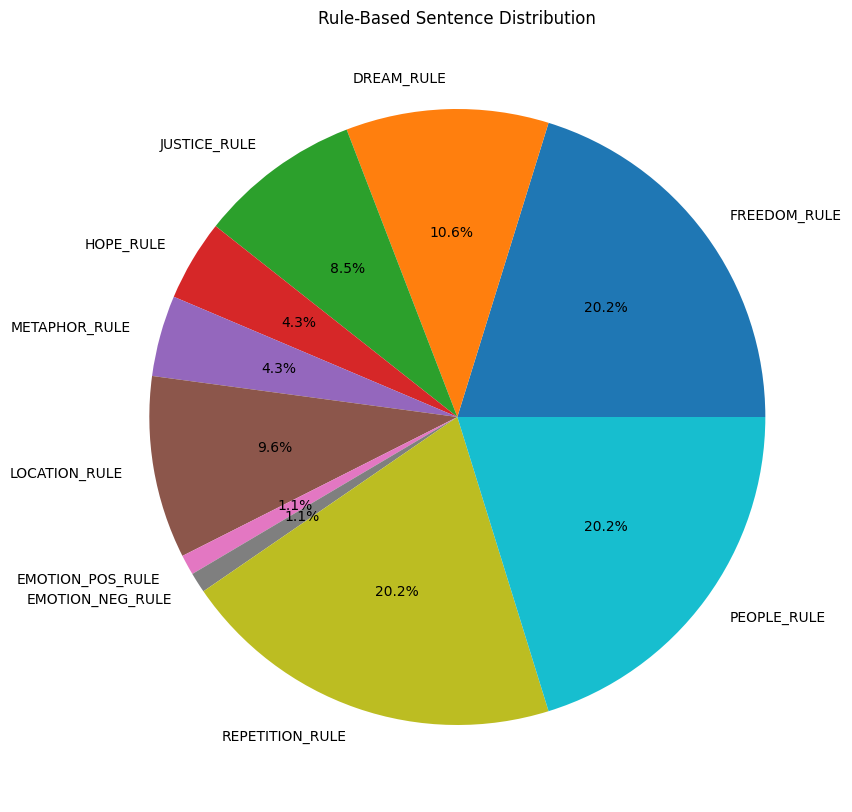

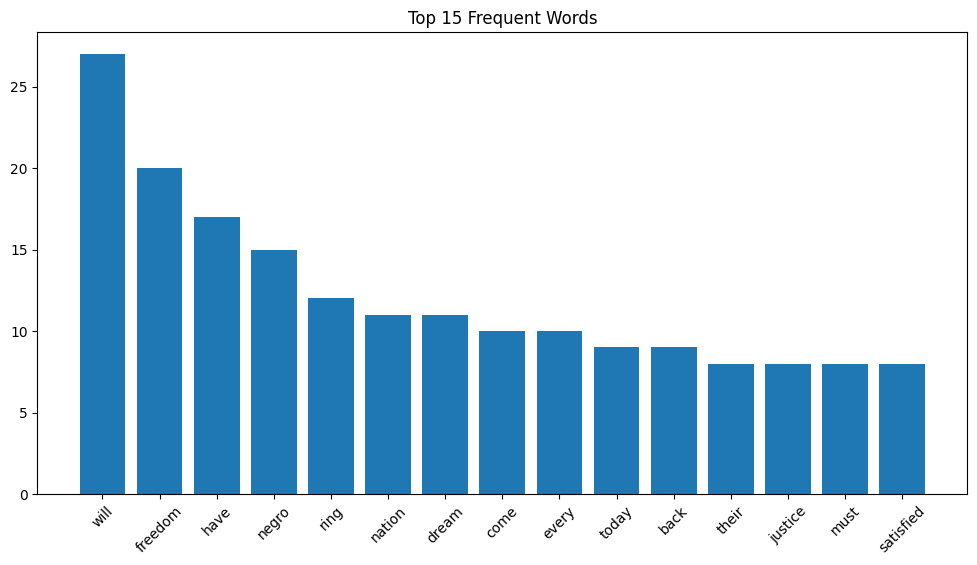

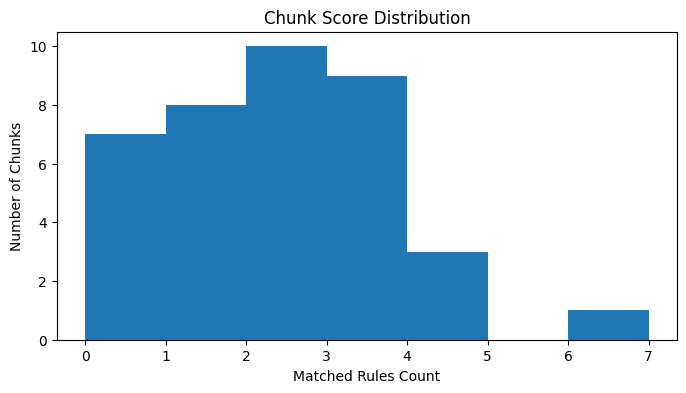

In [14]:
# Pie chart for rule distribution
labels = [r for r,c in rule_counts.items() if c>0]
sizes  = [c for r,c in rule_counts.items() if c>0]

plt.figure(figsize=(10,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Rule-Based Sentence Distribution")
plt.show()

# Bar chart for frequent words
top_words = word_counts.most_common(15)
plt.figure(figsize=(12,6))
plt.bar([w for w,_ in top_words], [c for _,c in top_words])
plt.xticks(rotation=45)
plt.title("Top 15 Frequent Words")
plt.show()

# Histogram for chunk scores
scores = [c["matched_rules_count"] for c in chunk_scores]
plt.figure(figsize=(8,4))
plt.hist(scores, bins=range(0, max(scores)+2))
plt.title("Chunk Score Distribution")
plt.xlabel("Matched Rules Count")
plt.ylabel("Number of Chunks")
plt.show()


In [ ]:
def compute_precision():
    stats = defaultdict(lambda: {"correct":0, "wrong":0})
    with open(MATCHES_TO_LABEL, 'r', encoding='utf-8') as f:
        rows = csv.DictReader(f)
        for r in rows:
            rule = r["rule"]
            val = r["correct (1|0)"]
            if val == "1": stats[rule]["correct"] += 1
            elif val == "0": stats[rule]["wrong"] += 1

    with open(PRECISION_OUT, "w", newline='', encoding='utf-8') as f:
        w = csv.writer(f)
        w.writerow(["rule","correct","wrong","precision"])
        for rule, d in stats.items():
            total = d["correct"] + d["wrong"]
            precision = d["correct"]/total if total else ""
            w.writerow([rule, d["correct"], d["wrong"], precision])

    print("Precision saved to:", PRECISION_OUT)

compute_precision()   # RUN THIS ONLY AFTER LABELING CSV


Precision saved to: /content/drive/MyDrive/precision_summary.csv
